In [73]:
#Importing libraries

#core
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
import seaborn as sns
import plotly.express as px

#document import
#from google.colab import drive
#drive.mount('/content/drive')

#statistics
from sklearn.decomposition import PCA

###Context
Last week I got a surprise: an invitation to vote in Kommunalvalg in Copenhagen. I was excited to get it, but knew little about the political landscape of the municipality (maybe 2 biggest parties).

For people like me, Danish news outlets like [DR](https://www.dr.dk/nyheder/politik/kommunalvalg/kandidattest) and [TV2](https://nyheder.tv2.dk/kandidattest) created ‘Kandidattests’ to help you find the candidates whose views on the hottest issues align the most with yours. I took them both and got some recommendations, but wasn't convinced by the results.

So, as a responsible voter and statistician, I decided to use the answers that were published and conduct my own research.

###Who is this for

- First-time voters who want to understand the landscape in general.
- Copenhageners who want to challenge their existing bias.

Although I'm sure that to most danes my findings will be obvious and they can contextualise them much better.

###DR and TV2 Kandidattest comparison

The tests contain 19-25 questions on the most popular issues. Some questions can be skipped, and some can be marked as "especially important". Once completed, the test will match you with the candidates that have the closest answers to yours based on Euclidean distance with weights.

1. **Question presentation**

 - DR: One question per page. It is possible to view "For" and "Against" arguments.
 - TV2: One question per page. No arguments provided.

I think in general, arguments create bias, but they are not automatically visible, so people only view them when in doubt.

2. **Answer scale**
 - DR: 4-point scale. Uenig - Lidt Uenig - Lidt Enig - Enig
 - TV2: 5-point scale: Helt uenig - Uenig - Neutral - Enig - Helt enig

I personally prefer DR's scale because it presents 2 middle options as variations of neutral, but allows to see your inclination while omitting 'true neutral'.

3. **Question phrasing**

- DR's questions are more open-ended.
  - Københavns Kommune skal fremme opførelsen af flere almene lejeboliger.
- TV2 frames them as a spectrum between 2 priorities.
  - Kommunen bør arbejde for, at der kan opføres flere billige lejeboliger, og at dette prioriteres på bekostning af ejerboliger samt kommunens profit på salg af byggegrunde.

On one hand, TV2 questions use the language from candidates' key issues (mærksager), so this phrasing might help to get a better feeling of specific candidate's position. On another hand, this approach may force candidates who propose alternative solutions into neutral answers and bundle them together with those who don't prioritise the topic in question (i.e. housing).

4. **'Especially important' issues**
- DR gives you an option to label the questions when you first see them.
- TV2 lets you choose 2 top areas (not questions) after answering all the questions.

5. **Result presentation**

- DR shows you top candidate matches. When opening the candidate page you can see their whole survey with your and their answers marked.
- TV2 shows both **candidates and parties** and summarizes your top agreement and disagreement areas with the top candidate.

I think including party alignment is great because it's important to know what the party stands for if your top candidate doesn't get a seat.

###Takeaways

Overall, I found **TV2**'s test more **user-friendly and informative**, but **DR**'s test to have a **better scale** and slightly better question phrasing, so I'll take the DR data for the analysis.

#### DR kandidattest: dataset description

Each candidate completed a survey with **19 questions** and filled **3 Mærksager** (key issues) . I assiged the following numeric values to the answers.

- Uenig 🙁 : -2
- Lidt Uenig 😕: -1
- Lidt Enig 🙂: 1
- Enig 😃: 2

I omitted number 3 as "true neutral", so the scale highlights whether responses go in opposite directions rather than how strong they are.

For the sake of this analysis I excluded the names of the candidates and kept only their anonymous ids.

In [74]:
sheet_id = "1HYdt-xpyl6jRDNAqpg359xXtHu-5BfX4kBTfTfcw9Q8"
sheet_name = "survey"

url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

df_raw = pd.read_csv(url)
df_raw = df_raw.reset_index(drop=True)
df_raw

,id,party_code,party_name,cand_number,cand_id,issue_1,issue_2,issue_3,q1,q2,...,q10,q11,q12,q13,q14,q15,q16,q17,q18,q19
0,1,A,Socialdemokratiet,1,A_1,Gratis vuggestuer og børnehaver: Det er blevet...,Sikre parkeringspladser nok i København: Jeg v...,Et mere retfærdigt boligmarked: Vi har fået al...,-1.0,-1.0,...,1.0,1.0,-2.0,2.0,1.0,2.0,2.0,2.0,1.0,-2.0
1,2,A,Socialdemokratiet,2,A_2,Børne- ungdomspolitik: Alt for mange børn mist...,"Ældre: Mange ældre føler sig ensomme, og det k...",Klima- og Miljø: Grønne byrum med vilde plante...,-1.0,-1.0,...,1.0,1.0,-2.0,2.0,-1.0,2.0,1.0,1.0,1.0,-1.0
2,3,A,Socialdemokratiet,3,A_3,Flere billige boliger: København skal have råd...,En stærk socialpolitik: Sagsbehandlerne løber ...,Udvikling i alle bydele: København skal udvikl...,-1.0,-2.0,...,-1.0,1.0,-2.0,2.0,-1.0,2.0,1.0,1.0,1.0,-1.0
3,4,A,Socialdemokratiet,4,A_4,Billige boliger - med plads til alle: Københav...,Bedre skoler - mere faglighed: Alle børn skal ...,Lokal velfærd - respekt for dine skattekroner:...,-1.0,1.0,...,1.0,1.0,-2.0,2.0,1.0,2.0,2.0,2.0,1.0,-2.0
4,5,A,Socialdemokratiet,5,A_5,Stærke fællesskaber og trygge rammer for alle ...,Et København hvor familielivet hænger sammen –...,NaN,-1.0,-1.0,...,1.0,1.0,-2.0,1.0,1.0,2.0,1.0,1.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,257,Å,Alternativet,7,Å_7,Klima og biodiversitet,Bedre forhold for cykler og offentlig transport,Flere boliger i den eksisterende boligmasse,-1.0,-2.0,...,-2.0,1.0,-2.0,-2.0,-2.0,2.0,1.0,1.0,-2.0,2.0
257,258,Å,Alternativet,8,Å_8,Billigere boliger,Bedre offentlig transport: Særligt busser,Sikre kvaliteten i børn og unges fritidstilbud...,-2.0,-2.0,...,-2.0,2.0,-2.0,-2.0,-2.0,2.0,1.0,-2.0,-2.0,2.0
258,259,Å,Alternativet,9,Å_9,Stop Lynetteholmprojektet: Det påstås gang på ...,Bedre forhold for gående og cyklister: Københa...,Sammen løser vi udfordringerne: Jeg vil arbejd...,-1.0,-2.0,...,-1.0,-1.0,-2.0,-2.0,-1.0,2.0,1.0,-1.0,-2.0,1.0
259,260,Å,Alternativet,10,Å_10,Bilerne skal ud af københavn: I københavn er b...,Lynetteholmen: Der skal laves en folkeafstemni...,Letbane til amager: Vi skal genoverveje letban...,1.0,-1.0,...,1.0,1.0,-2.0,-2.0,-2.0,2.0,-2.0,1.0,-2.0,2.0


In [75]:
# EDA
def summary_table(df):
    summary = pd.DataFrame({
        'dtype': df.dtypes,
        'missing_values': df.isnull().sum(),
        'unique_values': df.nunique()
    })

    # Add numeric stats
    numeric_df = df.select_dtypes(include='number')
    summary['mean'] = numeric_df.mean()
    summary['std'] = numeric_df.std()
    summary['min'] = numeric_df.min()
    summary['max'] = numeric_df.max()

    return summary

In [76]:
summary_table(df_raw)

,dtype,missing_values,unique_values,mean,std,min,max
id,int64,0,261,131.000000,75.488410,1.0,261.0
party_code,object,0,24,NaN,NaN,NaN,NaN
party_name,object,0,24,NaN,NaN,NaN,NaN
cand_number,int64,0,30,10.528736,7.985331,1.0,30.0
cand_id,object,0,261,NaN,NaN,NaN,NaN
issue_1,object,37,224,NaN,NaN,NaN,NaN
issue_2,object,44,216,NaN,NaN,NaN,NaN
issue_3,object,57,204,NaN,NaN,NaN,NaN
q1,float64,30,4,-0.251082,1.431687,-2.0,2.0
q2,float64,32,4,-0.724891,1.353469,-2.0,2.0


- Parites and candidates: 24 Parties and 261 candidate, maximum 30 candidates per party.
- Missing key issues: only 37 candidates have no key issues.
- Missing questions: between 29 and 33 per question, which means that some candidates skipped the survey altogether, and some skipped individual questions.

In [77]:
# What is the distribution of missing answers?

question_cols = [col for col in df_raw.columns if col.startswith("q")]

# Count missing answers per candidate (row)
df_raw["skipped_q"] = df_raw[question_cols].isnull().sum(axis=1)

# Count how many candidates fall into each missing-count bucket
missing_summary = (
    df_raw["skipped_q"]
    .value_counts()
    .sort_index()
    .reset_index()
)

missing_summary.columns = ["missing_answers", "number_of_candidates"]
missing_summary

,missing_answers,number_of_candidates
0,0,222
1,1,3
2,2,3
3,3,1
4,5,1
5,9,1
6,10,1
7,14,1
8,19,28


- 8 candidates skipped between 1 and 4 questions
- 4 skipped between 5 and 14 answers
- 28 skipped the survey altogehter

Since the survey allows to skip up to 4 questions, I will label groups 2 and 3 as 'incomplete'.

In [78]:
# Creating helper columns
df_raw["complete"] = (df_raw["skipped_q"] <= 4).astype(int)

df_raw[question_cols] = df_raw[question_cols].fillna(0)
df_raw[question_cols] = df_raw[question_cols].astype(int)

#df_raw["top"] = (df_raw["cand_number"] == 1).astype(int)
#df_raw["top5"] = (df_raw["cand_number"] <= 5).astype(int)

df_raw = df_raw.drop(columns=["skipped_q"])

df_raw

,id,party_code,party_name,cand_number,cand_id,issue_1,issue_2,issue_3,q1,q2,...,q11,q12,q13,q14,q15,q16,q17,q18,q19,complete
0,1,A,Socialdemokratiet,1,A_1,Gratis vuggestuer og børnehaver: Det er blevet...,Sikre parkeringspladser nok i København: Jeg v...,Et mere retfærdigt boligmarked: Vi har fået al...,-1,-1,...,1,-2,2,1,2,2,2,1,-2,1
1,2,A,Socialdemokratiet,2,A_2,Børne- ungdomspolitik: Alt for mange børn mist...,"Ældre: Mange ældre føler sig ensomme, og det k...",Klima- og Miljø: Grønne byrum med vilde plante...,-1,-1,...,1,-2,2,-1,2,1,1,1,-1,1
2,3,A,Socialdemokratiet,3,A_3,Flere billige boliger: København skal have råd...,En stærk socialpolitik: Sagsbehandlerne løber ...,Udvikling i alle bydele: København skal udvikl...,-1,-2,...,1,-2,2,-1,2,1,1,1,-1,1
3,4,A,Socialdemokratiet,4,A_4,Billige boliger - med plads til alle: Københav...,Bedre skoler - mere faglighed: Alle børn skal ...,Lokal velfærd - respekt for dine skattekroner:...,-1,1,...,1,-2,2,1,2,2,2,1,-2,1
4,5,A,Socialdemokratiet,5,A_5,Stærke fællesskaber og trygge rammer for alle ...,Et København hvor familielivet hænger sammen –...,NaN,-1,-1,...,1,-2,1,1,2,1,1,1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,257,Å,Alternativet,7,Å_7,Klima og biodiversitet,Bedre forhold for cykler og offentlig transport,Flere boliger i den eksisterende boligmasse,-1,-2,...,1,-2,-2,-2,2,1,1,-2,2,1
257,258,Å,Alternativet,8,Å_8,Billigere boliger,Bedre offentlig transport: Særligt busser,Sikre kvaliteten i børn og unges fritidstilbud...,-2,-2,...,2,-2,-2,-2,2,1,-2,-2,2,1
258,259,Å,Alternativet,9,Å_9,Stop Lynetteholmprojektet: Det påstås gang på ...,Bedre forhold for gående og cyklister: Københa...,Sammen løser vi udfordringerne: Jeg vil arbejd...,-1,-2,...,-1,-2,-2,-1,2,1,-1,-2,1,1
259,260,Å,Alternativet,10,Å_10,Bilerne skal ud af københavn: I københavn er b...,Lynetteholmen: Der skal laves en folkeafstemni...,Letbane til amager: Vi skal genoverveje letban...,1,-1,...,1,-2,-2,-2,2,-2,1,-2,2,1


In [79]:
# Do 'missing answers' and 'missing issues' subsets overlap?

issue_cols = [col for col in df_raw.columns if col.startswith("issue")]
df_raw["has_key_issues"] = df_raw[issue_cols].notnull().any(axis=1).astype(int)

key_issues_pivot = (
    df_raw
    .pivot_table(
        index="has_key_issues",
        columns="complete",
        values="cand_id",
        aggfunc="nunique",
        fill_value=0
    )
)

key_issues_pivot

complete,0,1
has_key_issues,,
0,26,11
1,6,218


Majority of candidates either completed or skipped both the survey and the key issues.
<br>

However, when it comes to candidates who completed only have one of the two, more candidates engaged with survey rather than Key Issues.

In [80]:
df_raw["is_active"] = ((df_raw["has_key_issues"] == 1) & (df_raw["complete"] == 1)).astype(int)
df_raw

,id,party_code,party_name,cand_number,cand_id,issue_1,issue_2,issue_3,q1,q2,...,q13,q14,q15,q16,q17,q18,q19,complete,has_key_issues,is_active
0,1,A,Socialdemokratiet,1,A_1,Gratis vuggestuer og børnehaver: Det er blevet...,Sikre parkeringspladser nok i København: Jeg v...,Et mere retfærdigt boligmarked: Vi har fået al...,-1,-1,...,2,1,2,2,2,1,-2,1,1,1
1,2,A,Socialdemokratiet,2,A_2,Børne- ungdomspolitik: Alt for mange børn mist...,"Ældre: Mange ældre føler sig ensomme, og det k...",Klima- og Miljø: Grønne byrum med vilde plante...,-1,-1,...,2,-1,2,1,1,1,-1,1,1,1
2,3,A,Socialdemokratiet,3,A_3,Flere billige boliger: København skal have råd...,En stærk socialpolitik: Sagsbehandlerne løber ...,Udvikling i alle bydele: København skal udvikl...,-1,-2,...,2,-1,2,1,1,1,-1,1,1,1
3,4,A,Socialdemokratiet,4,A_4,Billige boliger - med plads til alle: Københav...,Bedre skoler - mere faglighed: Alle børn skal ...,Lokal velfærd - respekt for dine skattekroner:...,-1,1,...,2,1,2,2,2,1,-2,1,1,1
4,5,A,Socialdemokratiet,5,A_5,Stærke fællesskaber og trygge rammer for alle ...,Et København hvor familielivet hænger sammen –...,NaN,-1,-1,...,1,1,2,1,1,1,-1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,257,Å,Alternativet,7,Å_7,Klima og biodiversitet,Bedre forhold for cykler og offentlig transport,Flere boliger i den eksisterende boligmasse,-1,-2,...,-2,-2,2,1,1,-2,2,1,1,1
257,258,Å,Alternativet,8,Å_8,Billigere boliger,Bedre offentlig transport: Særligt busser,Sikre kvaliteten i børn og unges fritidstilbud...,-2,-2,...,-2,-2,2,1,-2,-2,2,1,1,1
258,259,Å,Alternativet,9,Å_9,Stop Lynetteholmprojektet: Det påstås gang på ...,Bedre forhold for gående og cyklister: Københa...,Sammen løser vi udfordringerne: Jeg vil arbejd...,-1,-2,...,-2,-1,2,1,-1,-2,1,1,1,1
259,260,Å,Alternativet,10,Å_10,Bilerne skal ud af københavn: I københavn er b...,Lynetteholmen: Der skal laves en folkeafstemni...,Letbane til amager: Vi skal genoverveje letban...,1,-1,...,-2,-2,2,-2,1,-2,2,1,1,1


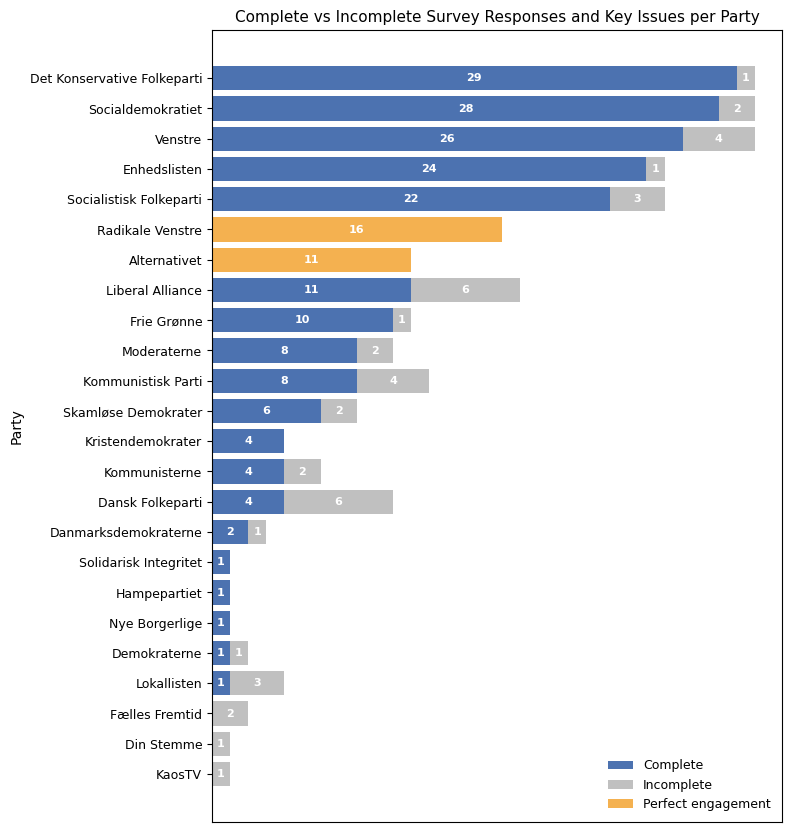

In [81]:
# Copy data
df = df_raw.copy()

# Pivot table: count unique candidates by party and complete status
pivot = df.pivot_table(
    index=['party_code', 'party_name'],
    columns='is_active',
    values='cand_id',  # unique candidate ID
    aggfunc='nunique',
    fill_value=0
).rename(columns={1: 'complete', 0: 'incomplete'}).reset_index()

# Total candidates per party
pivot['total_candidates'] = pivot['complete'] + pivot['incomplete']

# Share of complete candidates
pivot['share_complete'] = pivot['complete'] / pivot['total_candidates']

# Sort by number of complete, then share of complete
pivot = pivot.sort_values(by=['complete', 'share_complete'], ascending=[True, True]).reset_index(drop=True)

# Plot with smaller figure
fig, ax = plt.subplots(figsize=(8, max(4, len(pivot)*0.35)))  # reduced width and height per row

for idx, row in pivot.iterrows():
    y = idx

    # 100% completion bars filled with gold
    if row['share_complete'] == 1.0 and row['total_candidates'] >= 5:
        ax.barh(
            y=y,
            width=row['total_candidates'],
            color='#F4B150',
            edgecolor='none',
            label='_nolegend_'
        )
        ax.text(
            x=row['total_candidates']/2,
            y=y,
            s=str(row['total_candidates']),
            va='center',
            ha='center',
            color='white',
            fontweight='bold',
            fontsize=8  # smaller font
        )
    else:
        # Complete part
        if row['complete'] > 0:
            ax.barh(
                y=y,
                width=row['complete'],
                color='#4C72B0',
                label='_nolegend_'
            )
            ax.text(
                x=row['complete']/2,
                y=y,
                s=str(row['complete']),
                va='center',
                ha='center',
                color='white',
                fontweight='bold',
                fontsize=8
            )
        # Incomplete part
        if row['incomplete'] > 0:
            ax.barh(
                y=y,
                width=row['incomplete'],
                left=row['complete'],
                color='silver',
                label='_nolegend_'
            )
            ax.text(
                x=row['complete'] + row['incomplete']/2,
                y=y,
                s=str(row['incomplete']),
                va='center',
                ha='center',
                color='white',
                fontweight='bold',
                fontsize=8
            )

# Legend
legend_elements = [
    Patch(facecolor='#4C72B0', label='Complete'),
    Patch(facecolor='silver', label='Incomplete'),
    Patch(facecolor='#F4B150', edgecolor='none', label='Perfect engagement')
]

# Position legend at top-right inside the axes
ax.legend(handles=legend_elements, loc='lower right', fontsize=9, frameon=False)

# Y-axis labels
ax.set_yticks(range(len(pivot)))
ax.set_yticklabels(pivot['party_name'], fontsize=9)  # smaller y-axis labels
ax.set_ylabel('Party', fontsize=10)
ax.set_title('Complete vs Incomplete Survey Responses and Key Issues per Party', fontsize=11)

# Remove x-axis scale
ax.xaxis.set_visible(False)

# Remove grid lines
ax.grid(False)

plt.tight_layout(pad=1.0)
plt.show()

###Key insights:

- Most **big parties** with 21-30 candidates show **high share** of candidates with all answers.
- **Mid-sized** parties vary in answer availability, there are both parties with the smallest and the largest share of candidates with answers. **All the candidates** from <font color="#A022B6"><b>Radikale Venstre</b></font> and <font color="#237B2D"><b>Alternativet</b></font> provided their key issues and answered survey.

<br>

<h4>Parties with the highest and lowest Key Issues or Survey engagement</h4>

<table border="1">
  <tr>
    <th><h5>Highest</h5></th>
    <th><h5>Lowest</h5></th>
  </tr>
  <tr>
    <td>
      <ul>
        <li>Radikale Venstre <font color="#A022B6"><b>(B)*</b></font></li>
        <li>Alternativet <font color="#237B2D"><b>(Å)*</b></font></li>
        <li> Det Konservative Folkeparti <font color="#7DAE00"><b>(C)</b></font></li>
        <li> Enhedslisten <font color="#F25700"><b>(Ø)</b></font></li>
      </ul>
    </td>
    <td>
      <ul>
        <li> Dansk Folkeparti <font color="#F2A900"><b>(O)</b></font></li>
        <li> Liberal Alliance <font color="#00A8D9"><b>(I)</b></font></li>
        <li> Kommunistisk Parti <font color="#cc0000"><b>(R)</b></font></li>
      </ul>
    </td>
  </tr></table>



In [82]:
# Survey analysis

question_cols = [col for col in df_raw.columns if col.startswith("q")]
cols_to_keep = ["party_code", "party_name", "cand_id"] + question_cols

df_surv = df_raw[df_raw["complete"] == 1][cols_to_keep].copy().reset_index(drop=True)
df_surv

,party_code,party_name,cand_id,q1,q2,q3,q4,q5,q6,q7,...,q10,q11,q12,q13,q14,q15,q16,q17,q18,q19
0,A,Socialdemokratiet,A_1,-1,-1,-1,1,1,1,2,...,1,1,-2,2,1,2,2,2,1,-2
1,A,Socialdemokratiet,A_2,-1,-1,-1,1,1,1,1,...,1,1,-2,2,-1,2,1,1,1,-1
2,A,Socialdemokratiet,A_3,-1,-2,-1,1,2,1,2,...,-1,1,-2,2,-1,2,1,1,1,-1
3,A,Socialdemokratiet,A_4,-1,1,-1,1,1,1,2,...,1,1,-2,2,1,2,2,2,1,-2
4,A,Socialdemokratiet,A_5,-1,-1,-1,1,-2,1,1,...,1,1,-2,1,1,2,1,1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,Å,Alternativet,Å_7,-1,-2,-2,2,1,1,2,...,-2,1,-2,-2,-2,2,1,1,-2,2
225,Å,Alternativet,Å_8,-2,-2,-2,-1,2,1,2,...,-2,2,-2,-2,-2,2,1,-2,-2,2
226,Å,Alternativet,Å_9,-1,-2,-1,-2,-2,1,2,...,-1,-1,-2,-2,-1,2,1,-1,-2,1
227,Å,Alternativet,Å_10,1,-1,-2,1,-1,1,2,...,1,1,-2,-2,-2,2,-2,1,-2,2


In [83]:
'''
party_counts = df_survey['party_code'].value_counts()
valid_parties = party_counts[party_counts >= 10].index

df_surv = df_survey[df_survey['party_code'].isin(valid_parties)].reset_index(drop=True)
df_surv
'''

"\nparty_counts = df_survey['party_code'].value_counts()\nvalid_parties = party_counts[party_counts >= 10].index\n\ndf_surv = df_survey[df_survey['party_code'].isin(valid_parties)].reset_index(drop=True)\ndf_surv\n"

In [84]:
# Create diverging colormap from Blue to Orange
#https://www.hslpicker.com/#f48e00
cmap_BlOr = LinearSegmentedColormap.from_list( "BlueWhiteOrange", ['#4C72B0', '#FFFFFF', '#F4B150'] )
cmap_BlOr2 = LinearSegmentedColormap.from_list( "BlueWhiteOrange", ['#345892', '#FFFFFF', '#E48B0E'] )
cmap_BlOr3 = LinearSegmentedColormap.from_list( "BlueWhiteOrange", ['#1A4B99', '#FFFFFF', '#D97F00'] )

In [85]:
# Getting question texts
sheet_quest = "questions"

url_quest = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_quest}"

df_quest = pd.read_csv(url_quest)
df_quest = df_quest.reset_index(drop=True)
df_quest.head()

,q_num,section,question
0,q1,Økonomi,Flere opgaver i den offentlige sektor skal fre...
1,q2,Social & Velfærd,Offentlige institutioner tager for mange hensy...
2,q3,Trafik & Transport,Investering i vejnettet haster mere end invest...
3,q4,Økonomi,Det er muligt at spare penge i den offentlige ...
4,q5,Social & Velfærd,Kommuneskatten i Københavns Kommune skal sætte...


In [86]:
# 0) Prepare df_quest lookup table
df_quest_lookup = df_quest.set_index("q_num")


# 1) Helper: filter valid parties

def filter_parties(df, min_size=10):
    party_sizes = df['party_code'].value_counts()
    valid = party_sizes[party_sizes >= min_size].index
    df_filtered = df[df['party_code'].isin(valid)]
    return df_filtered, party_sizes.loc[valid]


# 2) Helper: compute STD matrix (original or binary)

def compute_std(df, question_cols, to_binary=False, party_order=None):
    work = df.copy()

    if to_binary:
        work[question_cols] = (work[question_cols] > 0).astype(int)

    std_mat = work.groupby("party_code")[question_cols].std()

    if party_order is not None:
        std_mat = std_mat.loc[party_order.index]

    return std_mat.round(2).T   # transpose → rows = questions


# 3) Helper: Replace q1→(shortened question text)

def shorten_question_text(text, max_len=60):
    text = str(text)
    return text if len(text) <= max_len else text[:max_len] + "…"

def replace_question_ids_with_short_text(std_matrix, df_quest_lookup, max_len=80):
    std_matrix = std_matrix.copy()

    # Build all labels first
    labels = []
    for qid in std_matrix.index:
        if qid in df_quest_lookup.index:
            full = df_quest_lookup.loc[qid, "question"]
            short = shorten_question_text(full, max_len=max_len)
            labels.append(f"{qid} – {short}")
        else:
            labels.append(qid)

    # Determine longest label
    max_label_len = max(len(lbl) for lbl in labels)

    # Apply uniform padding
    uniform_labels = [lbl.ljust(max_label_len) for lbl in labels]

    std_matrix.index = uniform_labels
    return std_matrix


# 4) Plot heatmap

def plot_std_heatmap(std_matrix, title, cbar_label, cmap, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        std_matrix,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        cbar_kws={'label': cbar_label}
    )

    # Move x-axis labels & label to the top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

    plt.title(title, pad=40)
    plt.xlabel("Party")
    plt.ylabel("Question")
    plt.tight_layout()
    plt.show()

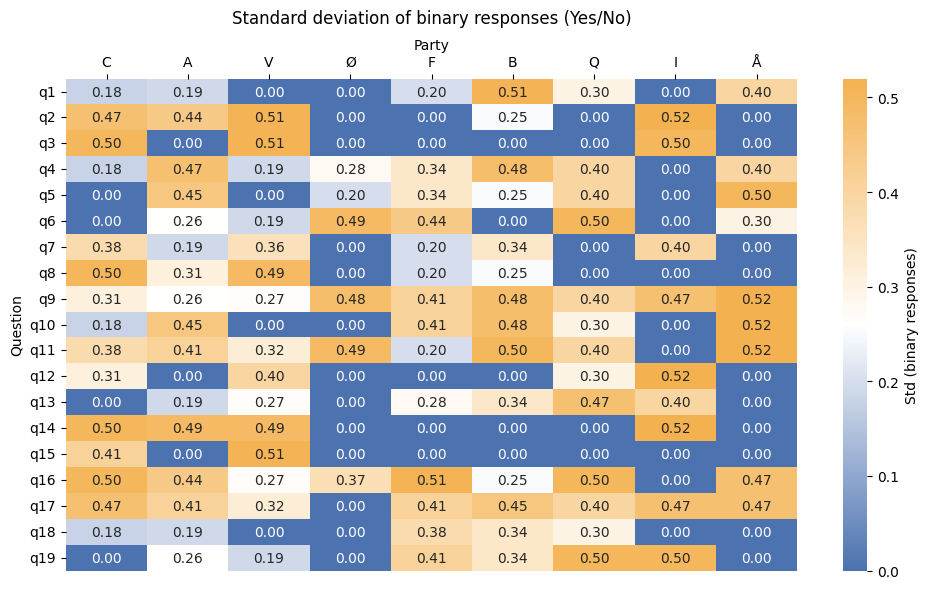

In [87]:
df = df_surv.copy()
question_cols = [f"q{i}" for i in range(1, 20)]

df_filt, party_order = filter_parties(df)

std_binary = compute_std(
    df_filt, question_cols,
    to_binary=True,
    party_order=party_order
)

plot_std_heatmap(
    std_binary,
    title="Standard deviation of binary responses (Yes/No)",
    cbar_label="Std (binary responses)",
    cmap=cmap_BlOr
)

####Directional agreement

This chart shows how much the response direction (positive or negative) varies within each party. The smaller the party, the lower the standard variation, so I will only look at the parties with at least 10 candidates who completed the survey.

**Key insights:**
- Most big parties (<b><font color="#7DAE00">C</font>, <font color="#D00000">A</font>, <font color="#1041C0">V</font>, <font color="#E600A8">F</font></b>). have **3-6** items on their agenda that they agree on, and have a mix of opinions about other topics.
- Enhedslisten <font color="#F25700"><b>(Ø)</b></font> lives up to its name: despite being a larger party it has the <b><font color="#F25700">lowest variance of responses</font></b>, and its members directionally agree on **13 of 19** questions.
- Liberal Alliance <font color="#00A8D9"><b>(I)</b></font> and Alternativet <font color="#237B2D"><b>(Å)</b></font>directionally agree on **10** questions within the parties.

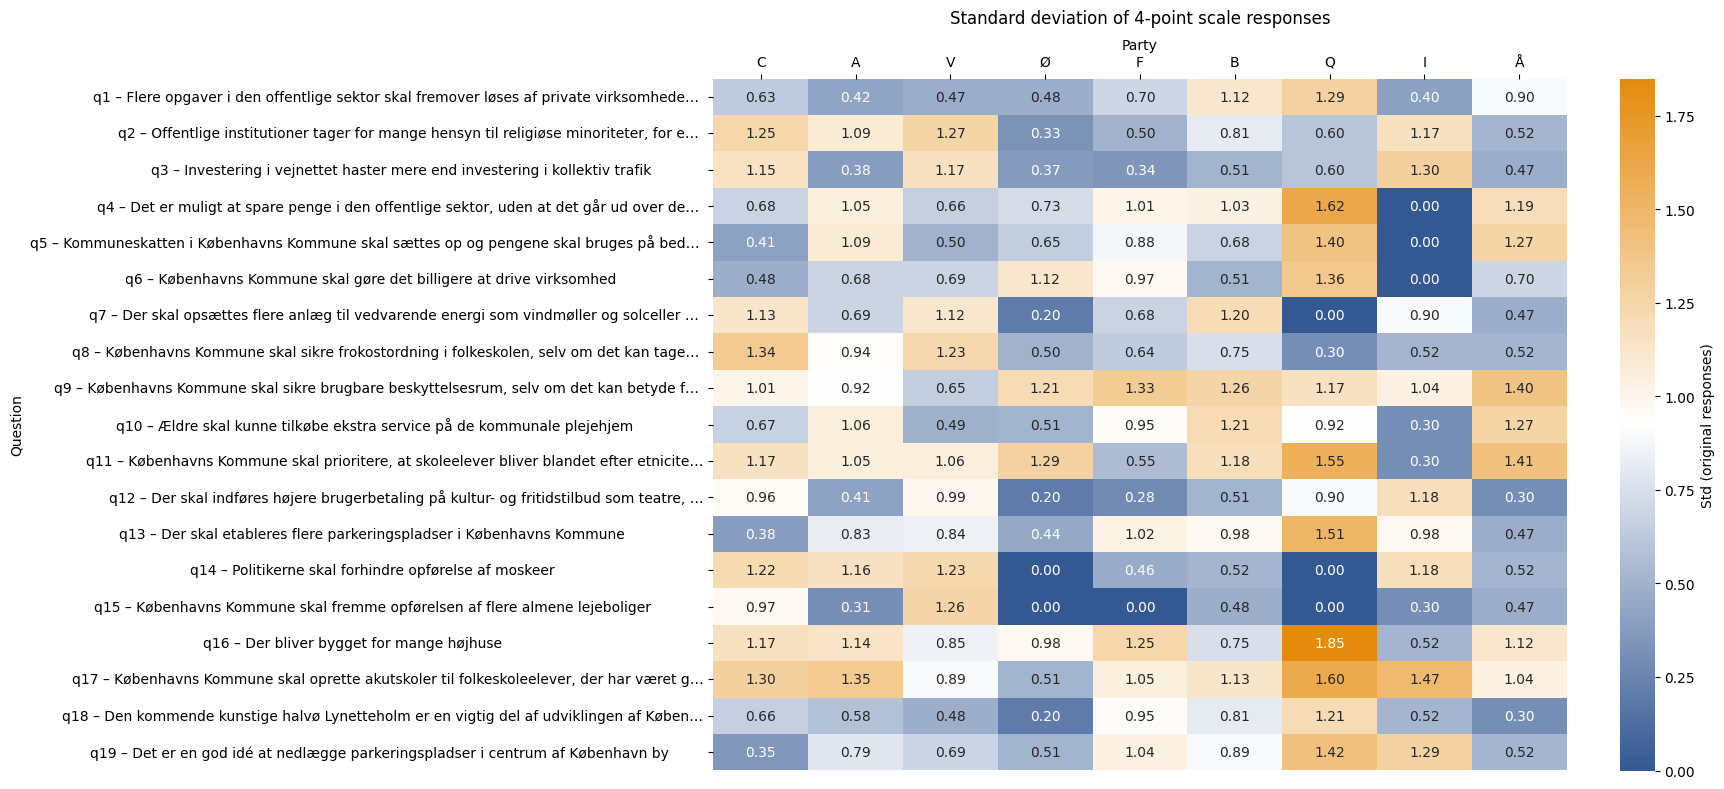

In [88]:
df = df_surv.copy()
question_cols = [f"q{i}" for i in range(1, 20)]

df_filt, party_order = filter_parties(df)

std_original = compute_std(
    df_filt, question_cols,
    to_binary=False,
    party_order=party_order
)

# q1 – some question text…
std_original_labeled = replace_question_ids_with_short_text(
    std_original,
    df_quest_lookup,
    max_len=80
)

plot_std_heatmap(
    std_original_labeled,
    title="Standard deviation of 4-point scale responses",
    cbar_label="Std (original responses)",
    cmap=cmap_BlOr2,
    figsize=(18, 8)
)

####Main focus

This chart highlights the questions that have the lowest variance in the original responses. Usually 0 variance would come from extreme responses (2 or -2) and show what are the issues that define the parties.

**Answer scale**:<br>
Uenig 😡 - Lidt Uenig ☹️ - Lidt Enig 🙂 - Enig 🥰
<br><br>
**Color scale interpretation**:
- <font color="#3a4487"><b>Dark blue</b></font>: identical answers, usually extreme
- <font color="#4C72B0"><b>Blue</b></font>: same direction, different magnitude (🙂 vs 🥰) or (☹️ vs 😡)
- White: answers range between 2 neutrals (🙂 vs ☹️)
- <font color="#F4B150"><b> Orange</b></font>: answers range between an extreme and a neutral in different direction (🙂 vs 😡) or (🥰 vs ☹️)
- <font color="#e48b0e"><b> Bright orange</b></font>: answers range between 2 extremes (🥰 vs 😡)
<br>

**Key insights**:

- The most burning question across all parties:
  - **KK skal fremme opførelsen af flere almene lejeboliger** got unanimous and extreme (positive or negative) responses in several parties (<b><font color="#E600A8">F</font>, <font color="#F25700">Ø</font>, <font color="#5ABE82">Q</font>, <font color="#D00000">A</font>, <font color="#00A8D9">I</font></b>).

- Strong agreement within the parties
   - Liberal Alliance <font color="#00A8D9"><b>(I)</b></font>: mosques, Lynetteholmen, green energy, culture
   - Enheslisten <font color="#F25700"><b>(Ø)</b></font>: mosques, Lynetteholmen, green energy, culture
   - Frie Grønne <font color="#5ABE82"><b>(Q)</b></font>: mosques, green energy, free meals in schools


- Strong opposing opinions within Frie Grønne <font color="#5ABE82"><b>(Q)</b></font>
   - The answers suggest disagreement on taxes, schools and high-rise buildings (q4, q10, q16).

In [123]:
def pca_heatmap(df, question_cols, df_quest, cmap=cmap_BlOr3, title="PCA Loadings per Question", plot_heatmap=True):
    """
    Performs PCA on selected columns of a dataset, calculates loadings,
    merges with question dataset, and optionally visualizes as a heatmap.

    Parameters:
    - df: pd.DataFrame, dataset containing the responses
    - question_cols: list of str, columns to include in PCA
    - df_quest: pd.DataFrame, dataset with question numbers and text
               must contain a column 'q_num' and 'question'
    - cmap: str, colormap for the heatmap
    - title: str, title for the heatmap chart
    - plot_heatmap: bool, whether to display the heatmap

    Returns:
    - df: pd.DataFrame, original df with PC1 and PC2 added
    - loadings: pd.DataFrame, loadings per question
    """
    # Copy dataset to avoid modifying original
    df = df.copy()

    # PCA computation
    X = df[question_cols].values
    pca = PCA(n_components=2)
    coords = pca.fit_transform(X)

    df["PC1"] = coords[:, 0]
    df["PC2"] = coords[:, 1]

    # Loadings
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=["PC1", "PC2"],
        index=question_cols
    ).reset_index().rename(columns={"index": "q_num"})

    loadings["q_num"] = loadings["q_num"].astype(str).str.strip()

    # Prepare question dataset
    df_quest = df_quest.copy()
    df_quest["q_num"] = df_quest["q_num"].astype(str).str.strip()

    # Merge loadings with question labels
    merged = pd.merge(loadings, df_quest, on="q_num", how="left")
    merged["label"] = merged["q_num"] + " - " + merged["question"]

    heatmap_data = merged.set_index("label")[["PC1", "PC2"]]

    # Plot heatmap if requested
    if plot_heatmap:
        plt.figure(figsize=(8, 6))
        sns.heatmap(heatmap_data, annot=True, cmap=cmap, center=0)
        plt.title(title)
        plt.xlabel("Principal Components")
        plt.ylabel("")
        plt.tight_layout()
        plt.show()

    return df, loadings

/tmp/ipython-input-1378500670.py:59: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



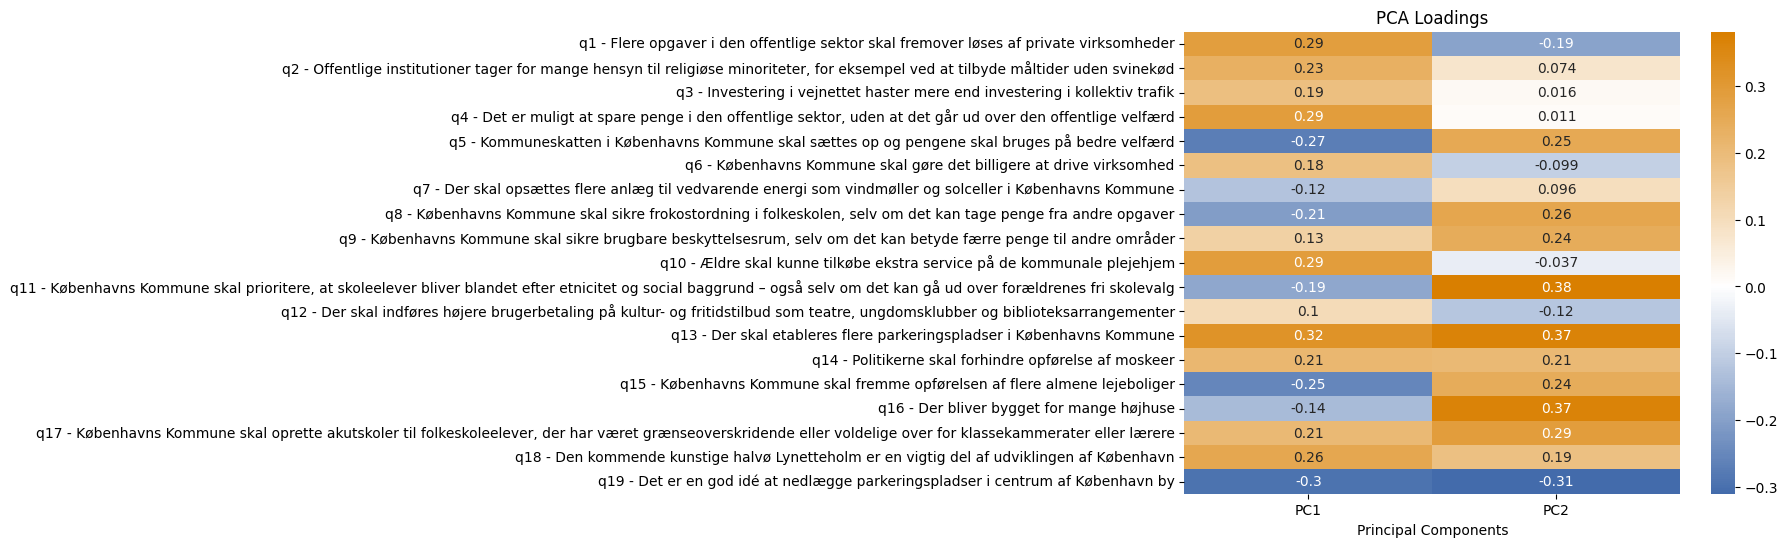

In [90]:
df_pca, loadings = pca_heatmap(
    df_surv,
    question_cols,
    df_quest,
    title="PCA Loadings"
)

In [91]:
#df_pca.head()

###PCA: Top questions influencing the axes.


####PC1
Candidates who score high on this axis are likely to:
- Agree with q13, q10, q4, q1, q18, and disagree with q19 and q5.
- General theme:
- **More parking spaces, privatize welfare, keep taxes and services low**. <br>

The candidates who scored low on this scale have opposing views: want to invest into welfare and public transport.

This axis represents a traditional <b><font color="#1041C0">"business</font> vs <font color="#D00000">welfare"</font></b> orientation. <br>


####PC2
Candidates who score high on this axis are likely to:
- Agree with q11, q13, q16, q17, q8, and disagree with: q19.
- General theme:
- **Changes in schools** (ensure diversity, isolate disruptive students, provie free lunch), **more parking spaces, reduce high-rise construction, tax increase.**

The candidates who scored low on this scale have opposing views: don't believe in akutscoler, rely on public transport, support high-rise buildings, oppose tax increase.

This axis measures orientation on <b><font color="#F2A900">"families</font> vs <font color="#7DAE00"> youth"</font></b> .

**Note**: The questions related to **parking** contribute to **both axes**.
This means that combined with other questions, scoring high on this topic can mean that you are leaning <b><font color="#1041C0">business</font></b> and/or <b><font color="#F2A900">family</font></b>.

In [126]:
import plotly.graph_objects as go

def pca_candidate_scatter(
    df,
    title="Candidate PCA Map",
    toggle="major",
    x_label="PC1",
    y_label="PC2",
    use_custom_markers=True
):
    """
    Visualizes PCA coordinates of candidates, highlighting top candidates per party.
    Fully self-contained with color and shape assignments.

    Parameters:
    - df: pd.DataFrame containing at least ['PC1', 'PC2', 'party_code', 'cand_id']
    - title: str, chart title
    - toggle: str, which parties to highlight: "major", "minor", "all"
    - x_label: str, label for the x-axis
    - y_label: str, label for the y-axis

    Returns:
    - fig: plotly.graph_objects.Figure
    """
    # --- Define party colors and shapes ---
    major_parties = {
        "A": "#D00000", "F": "#E600A8", "V": "#1041C0", "B": "#A022B6",
        "C": "#7DAE00", "Ø": "#F25700", "I": "#00A8D9",
        "Å": "#1DA82D", "Q": "#21D2B4", "ME": "#E600A8"
    }

    major_shapes = {
        "ME": "diamond-x"
    }

    minor_parties = {
        "D": "#028F85", "J": "#681A1A", "K": "#45B3E0", "L": "#F25700",
        "M": "#591984", "N": "#6C1EA1", "P": "#D00000", "Æ": "#D00000",
        "RR": "#CC0000", "T": "#7245E0", "Y": "#681A1A", "Z": "#ff0090",
        "O": "#F2A900", "R": "#F2A900",
    }

    minor_shapes = {
        "P": "x", "R": "star", "Æ": "diamond-cross", "N": "x", "Y": "x", "K": "cross", "Z": "x", "T": "diamond", "J": "x"
    }

    default_color = "#E5E6F6"
    default_shape = "circle"

    # --- Helper: assign colors and shapes ---
    def assign_styles(df, toggle="major"):
        if not use_custom_markers:
            df["color"] = default_color
            df["shape"] = default_shape
            return

        colors, shapes = [], []

        for _, row in df.iterrows():
            party = row["party_code"]

            if toggle == "major":
                color = major_parties.get(party, default_color)
                shape = major_shapes.get(party, default_shape) if party in major_parties else minor_shapes.get(party, default_shape)

            elif toggle == "minor":
                color = minor_parties.get(party, default_color)
                shape = minor_shapes.get(party, default_shape)

            else:  # toggle == "all"
                color = major_parties.get(party, minor_parties.get(party, default_color))
                shape = major_shapes.get(party, minor_shapes.get(party, default_shape))

            colors.append(color)
            shapes.append(shape)

        df["color"] = colors
        df["shape"] = shapes

    # Copy df to avoid modifying original
    df = df.copy()
    df["top"] = df["cand_id"].apply(lambda cid: 1 if str(cid).split("_")[-1] == "1" else 0)

    # Party ordering: top candidates first
    parties_ordered = (
        df.groupby("party_code")["top"].max()
          .sort_values(ascending=False)
          .index.tolist()
    )

    # Assign initial style
    assign_styles(df, toggle=toggle)

    # --- Create figure ---
    fig = go.Figure()

    for party in parties_ordered:
        party_df = df[df["party_code"] == party]
        fig.add_trace(go.Scatter(
            x=party_df["PC1"],
            y=party_df["PC2"],
            mode="markers",
            name=party,
            marker=dict(
                color=party_df["color"],
                symbol=party_df["shape"],
                size = party_df.apply(lambda row: 18 if row["party_code"] == "ME" else 14 if row["top"] == 1 else 8, axis=1),
                opacity=0.8
            ),
            text=party_df["cand_id"]
        ))

    # --- Dropdown menu ---
    buttons = []
    for t in ["major", "minor", "all"]:
        assign_styles(df, toggle=t)
        colors_list = df.groupby("party_code")["color"].first().to_dict()
        symbols_list = df.groupby("party_code")["shape"].first().to_dict()

        buttons.append(dict(
            label=t.capitalize(),
            method="update",
            args=[
                {
                    "marker.color": [colors_list[p] for p in parties_ordered],
                    "marker.symbol": [symbols_list[p] for p in parties_ordered]
                },
                {"title": f"{title} (toggle: {t})"}
            ]
        ))

    fig.update_layout(
        updatemenus=[dict(
            type="dropdown",
            showactive=True,
            buttons=buttons,
            x=1.15,
            y=1
        )],
        title=title,
        xaxis_title=x_label,
        yaxis_title=y_label,
        legend_title="Party"
    )

    return fig

In [93]:
fig = pca_candidate_scatter(
    df_pca,
    title="All Candidates PCA Map",
    toggle="major",
    x_label="Welfare → Business",
    y_label="Youth → Family"
)
fig.show()

**Note**: The axes represent the <b><font color="#F00020">differences between the extremes within this dataset, not absolute political spectrum</font></b>. Bigger dots represent #1 candidates in the party lists.
<br>
###Key insights:

####<b><font color="#D00000">Red</font> → <font color="#1041C0">Blue</font></b>

Because the dataset is mostly left-leaning, the most radical left parties pull the axes in their direction, therefore traditional left parties may appear more centrist or even slightly right by comparison, so all the assigned alignments are __relative__.

- **Furthest left**: Enhedslisten<b><font color="#F25700">(Ø)</font></b>, Frie Grønne <font color="#21D2B4"><b>(Q)</b></font>
- **Furthest right**: Liberal Alliance<b><font color="#00A8D9">(I)</font></b>, Det Konservative Folkeparti <font color="#7DAE00"><b>(C)</b></font>
- **Closest to center**: Radikale Venstre<b><font color="#9022B6">(B)</font></b>, Socialdemokratiet<b><font color="#F00020">(A)</font></b>

####<b><font color="#7DAE00">Youth</font> → <font color="#F2A900"> Family</font></b>

- **Most youth-oriented**: Liberal Alliance<b><font color="#00A8D9">(I)</font></b>
- **Most family-oriented**: Socialdemokratiet<b><font color="#F00020">(A)</font></b><br><br>

**Other insights**
- **Least overlap with major parties**:
  - Socialdemokratiet<b><font color="#F00020">(A)</font></b>, Radikale Venstre<b><font color="#9022B6">(B)</font></b>, Liberal Alliance<b><font color="#00A8D9">(I)</font></b>


Since there is a greater variation on the horizontal axis than on the vertical, and there are 2 apparent clusters on each side I will run another PCA on each side separately to see how left- and right-leaning parties differ from each other. The 'center' parties will be included in both.
[picture here]



In [94]:
'''
coords = pca.fit_transform(X)
# Assuming coords comes from your PCA fit on df_surv[question_cols]
df_pca['PC1'] = coords[:, 0]
df_pca['PC2'] = coords[:, 1]
'''
df_pca

,party_code,party_name,cand_id,q1,q2,q3,q4,q5,q6,q7,...,q12,q13,q14,q15,q16,q17,q18,q19,PC1,PC2
0,A,Socialdemokratiet,A_1,-1,-1,-1,1,1,1,2,...,-2,2,1,2,2,2,1,-2,1.077098,5.067062
1,A,Socialdemokratiet,A_2,-1,-1,-1,1,1,1,1,...,-2,2,-1,2,1,1,1,-1,0.421475,3.596140
2,A,Socialdemokratiet,A_3,-1,-2,-1,1,2,1,2,...,-2,2,-1,2,1,1,1,-1,-0.924636,3.703023
3,A,Socialdemokratiet,A_4,-1,1,-1,1,1,1,2,...,-2,2,1,2,2,2,1,-2,1.543900,5.214141
4,A,Socialdemokratiet,A_5,-1,-1,-1,1,-2,1,1,...,-2,1,1,2,1,1,1,-1,1.405501,2.372987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,Å,Alternativet,Å_7,-1,-2,-2,2,1,1,2,...,-2,-2,-2,2,1,1,-2,2,-4.420181,-0.413838
225,Å,Alternativet,Å_8,-2,-2,-2,-1,2,1,2,...,-2,-2,-2,2,1,-2,-2,2,-6.643568,-0.481190
226,Å,Alternativet,Å_9,-1,-2,-1,-2,-2,1,2,...,-2,-2,-1,2,1,-1,-2,1,-3.409494,-1.329045
227,Å,Alternativet,Å_10,1,-1,-2,1,-1,1,2,...,-2,-2,-2,2,-2,1,-2,2,-1.645731,-1.721058


In [95]:
# Creating subsets for left and right leaning candidates. Both include centrists.
df_left = df_pca[df_pca['PC1'] <= -2].copy()
df_right = df_pca[df_pca['PC1'] >= 2].copy()

df_left = df_left.drop(columns=['PC1', 'PC2'])
df_right = df_right.drop(columns=['PC1', 'PC2'])

print(len(df_left), len(df_right))

88 81


/tmp/ipython-input-1378500670.py:59: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



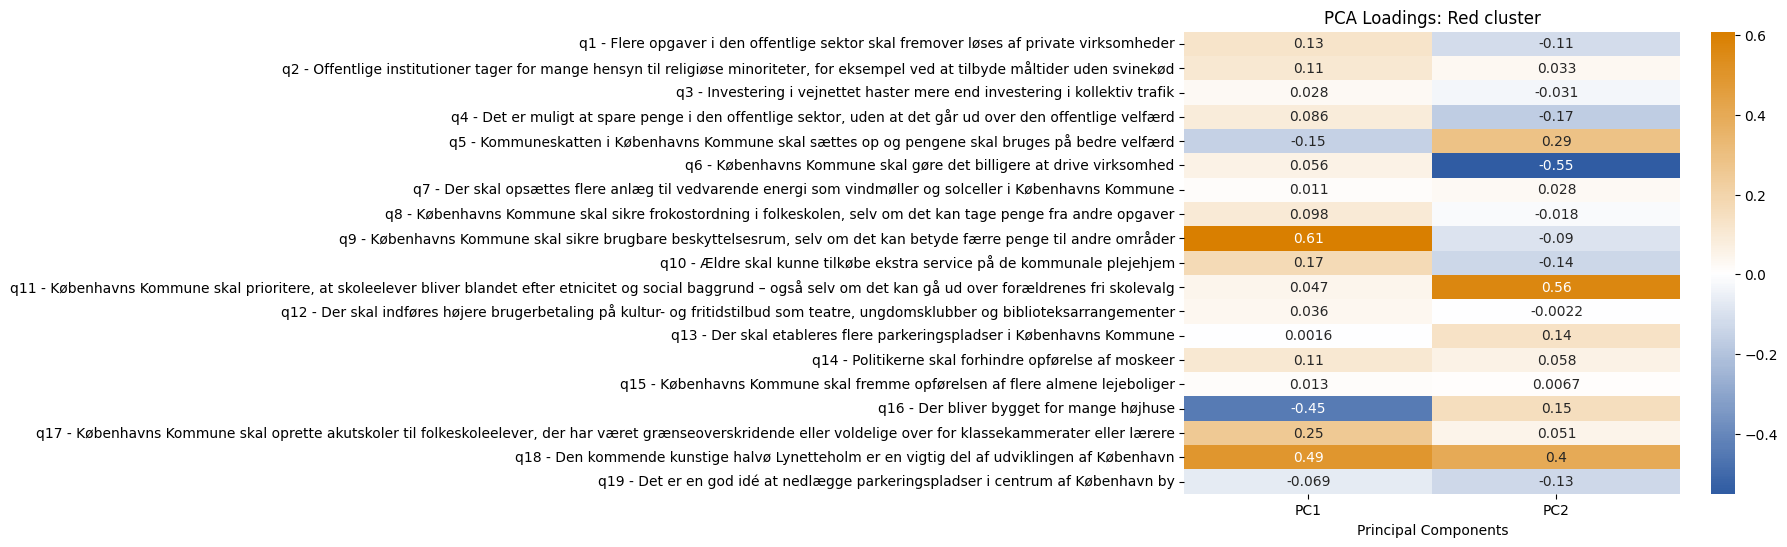

In [96]:
df_pca_left, loadings = pca_heatmap(
    df_left,
    question_cols,
    df_quest,
    title="PCA Loadings: Red cluster"
)

###Top questions influencing the axes (Red cluster)


####PC1
Candidates who score high on this axis are likely to:
- Agree with q9 and q18, and disagree q16
- General theme:
- **Preparing shelters, supporting new construction (including Lynetteholmen)**. <br>

The candidates who scored low on this scale have opposing views: don't see the need for shelters, oppose construction of Lynetteholmen and high-rise buildings.

####PC2
Candidates who score high on this axis are likely to:
- Agree with q11, q18 and q5, and disagree with: q6.
- General theme:
- **Integration-focused school policy, higher taxes**.

The candidates who scored low on this scale have opposing views: don't believe in akutscoler, rely on public transport, support high-rise buildings.

This time there is no common thread uniting top loadings in the principal components, so I'll just keep the keywords in their names.

In [97]:
fig = pca_candidate_scatter(
    df_pca_left,
    title='"Red" Candidate Mapping',
    toggle="all",
    x_label="Shelters, high buildings, Lynetteholmen →",
    y_label="School-mixing, higher taxes →"
)
fig.show()

###"Red" cluster - key Insights:

- **Top candidates similarity**:
   - Although the responses of their party members are spread out, number one candidates (possible mayors) from <b><font color="#F25700">Ø</font>, <font color="#237B2D">Å</font>, <font color="#E600A8">F</font></b> are closer to each other than to the centres of their party clusters.

- **Least overlap**:
   - Socialistisk Folkeparti <b><font color="#E600A8">(F)</font></b> - this is the most centrist party of this group.
- **Most overlap**:
   - Enhedslisten<b><font color="#F25700">(Ø)</font></b> and Alternativet <font color="#237B2D"><b>(Å)</b></font> are at the center of this cluster representing its middle-ground opinions.
   - Frie Grønne <font color="#21D2B4"><b>(Q)</b></font> and Kommunistisk Parti <font color="#E1A311"><b>(R)</b></font> : although similar to Enhedslisten on the general map, inside the red cluster these parties end up closer to the extreme end of the spectrum.

/tmp/ipython-input-1378500670.py:59: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



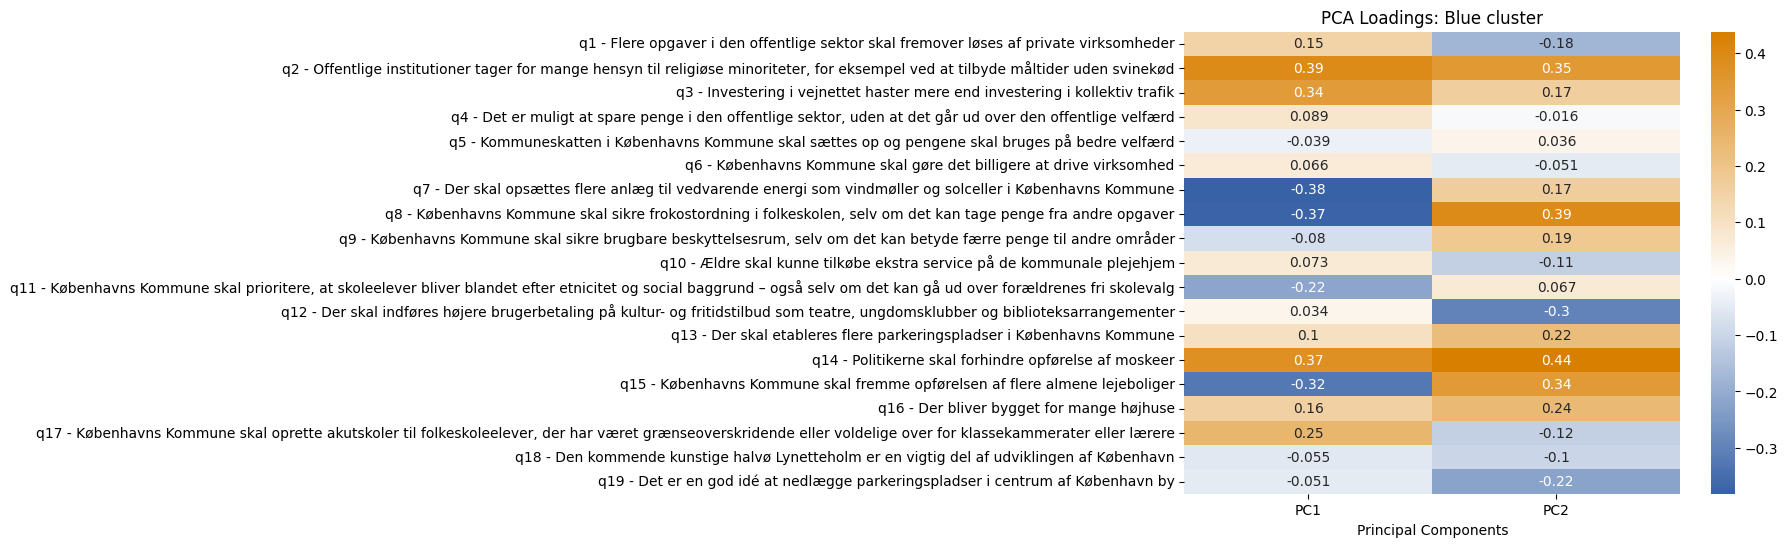

In [98]:
df_pca_right, loadings = pca_heatmap(
    df_right,
    question_cols,
    df_quest,
    title="PCA Loadings: Blue cluster"
)

###Top questions influencing the axes (Blue cluster)


####PC1
Candidates who score high on this axis are likely to:
- Agree with q2 and q14, and disagree q7 and q8
- General theme:
- **Religious freedom vs regulation**. <br>

The candidates who scored low on this scale have opposing views: don't see the need for shelters, oppose construction of Lynetteholmen and high-rise buildings.

####PC2
Candidates who score high on this axis are likely to:
- Agree with q14, q8 and q2
- General theme:
- **Public vs privatized welfare**.

The candidates who scored low on this scale have opposing views: don't believe in akutscoler, rely on public transport, support high-rise buildings.

This time there is no common thread uniting top loadings in the principal components, so I'll just keep the keywords in their names.

In [99]:
fig = pca_candidate_scatter(
    df_pca_right,
    title='"Blue" Candidate Mapping',
    toggle="all",
    x_label="Religious skepticism → ",
    y_label="← Private welfare"
)
fig.show()

###"Blue" cluster - key Insights:

- **Top candidates similarity**:
   - Just like in the red cluster, the answers of 3 blue party frontrunners (<b><font color="#1041C0">V</font>, <font color="#237B2D">C</font>, <font color="#F2A900">O</font></b>) are closer to each other, and further from the center than their party averages.
- **Most overlap**:
   - Venstre<b><font color="#1041C0">(V)</font></b> and Det Konservative Folkeparti <font color="#237B2D"><b>(C)</b></font> are at the center of this cluster representing its middle-ground opinions.
- **Least overlap**:
   - Liberal Alliance<b><font color="#00A8D9">(I)</font></b> is still the only larger party to stand out, mostly due to radical anti-regulation agenda.

In [100]:
df_test = df_surv.copy()

# Example: create a dictionary with all fields
test_answers = {
    "party_code": "ME",
    "party_name": "My test",
    "cand_id": "ME_1",
    "q1": -1,
    "q2": -1,
    "q3": -1,
    "q4": 1,
    "q5": -2,
    "q6": 1,
    "q7": 1,
    "q8": -1,
    "q9": 1,
    "q10": -2,
    "q11": -1,
    "q12": -1,
    "q13": -1,
    "q14": -1,
    "q15": 1,
    "q16": -2,
    "q17": -1,
    "q18": -1,
    "q19": -1
}

# Append test answers
df_test = pd.concat([df_test, pd.DataFrame([test_answers])], ignore_index=True)

df_test.tail()

,party_code,party_name,cand_id,q1,q2,q3,q4,q5,q6,q7,...,q10,q11,q12,q13,q14,q15,q16,q17,q18,q19
225,Å,Alternativet,Å_8,-2,-2,-2,-1,2,1,2,...,-2,2,-2,-2,-2,2,1,-2,-2,2
226,Å,Alternativet,Å_9,-1,-2,-1,-2,-2,1,2,...,-1,-1,-2,-2,-1,2,1,-1,-2,1
227,Å,Alternativet,Å_10,1,-1,-2,1,-1,1,2,...,1,1,-2,-2,-2,2,-2,1,-2,2
228,Å,Alternativet,Å_11,-1,-1,-1,-1,-1,1,1,...,1,-1,-2,-1,-1,1,1,1,-2,1
229,ME,My test,ME_1,-1,-1,-1,1,-2,1,1,...,-2,-1,-1,-1,-1,1,-2,-1,-1,-1


In [124]:
df_pca_test, loadings = pca_heatmap(df_test, question_cols, df_quest, plot_heatmap=False)

In [125]:
fig = pca_candidate_scatter(
    df_pca_test,
    title='My results',
    toggle="all",
    x_label="Welfare → Business",
    y_label="Youth → Family"
)
fig.show()

### My results

I completed the test on DR website providing the answers in the dataset df_test.
The DR test predicted **83% agreement** with 3 candidates from <b><font color="#1041C0">Venstre</font>, <font color="#237B2D">Det Konservative Folkeparti</font> and <font color="#9022B6">Radikale Venstre</font></b> that are relatively close my placement on the PCA chart, but not the closest.

According to PCA, **most of my top candidates** are from <b><font color="#9022B6">Radikale Venstre</font></b>.